In [24]:
from models import  vae_hyp_celeba, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 102400))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
size= len(trainset_1)
train_data, val_data = torch.utils.data.random_split(trainset_1, [int(size-size*0.2), int(size*0.2)])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                         num_workers=1, pin_memory=True, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

In [27]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [28]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            # Evaluate loss
            #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
            #loss = BCE + (vae.encoder.kl)
            loss = loss_function(recon_x, x, mu, logvar)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [29]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      img = img.to(device)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/5 	 train loss 247.538 	 validation loss 174.273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


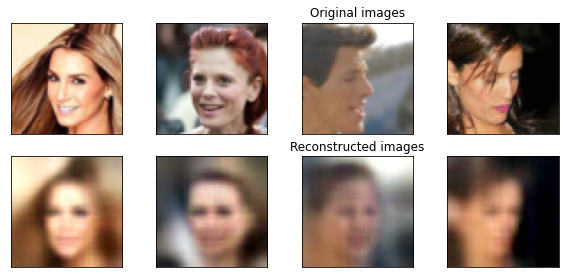

	 partial train loss (single batch): 12926.017578
	 partial train loss (single batch): 11341.091797
	 partial train loss (single batch): 10031.216797
	 partial train loss (single batch): 11614.439453
	 partial train loss (single batch): 9799.263672
	 partial train loss (single batch): 9344.003906
	 partial train loss (single batch): 10710.851562
	 partial train loss (single batch): 9986.614258
	 partial train loss (single batch): 9514.178711
	 partial train loss (single batch): 9070.710938
	 partial train loss (single batch): 10403.278320
	 partial train loss (single batch): 9340.781250
	 partial train loss (single batch): 9670.084961
	 partial train loss (single batch): 11927.490234
	 partial train loss (single batch): 9478.145508
	 partial train loss (single batch): 9545.349609
	 partial train loss (single batch): 10124.835938
	 partial train loss (single batch): 9589.502930
	 partial train loss (single batch): 9055.910156
	 partial train loss (single batch): 8919.455078
	 partial tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 2/5 	 train loss 128.425 	 validation loss 113.632


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


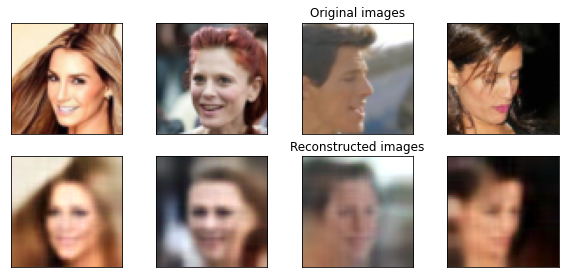

	 partial train loss (single batch): 7265.094727
	 partial train loss (single batch): 7800.917480
	 partial train loss (single batch): 7463.558105
	 partial train loss (single batch): 6670.822266
	 partial train loss (single batch): 6738.687500
	 partial train loss (single batch): 7609.469727
	 partial train loss (single batch): 7163.620117
	 partial train loss (single batch): 7136.612793
	 partial train loss (single batch): 7795.017578
	 partial train loss (single batch): 7409.445801
	 partial train loss (single batch): 7032.995605
	 partial train loss (single batch): 7005.334473
	 partial train loss (single batch): 7355.589844
	 partial train loss (single batch): 7303.457031
	 partial train loss (single batch): 7030.173340
	 partial train loss (single batch): 7805.803711
	 partial train loss (single batch): 6895.763184
	 partial train loss (single batch): 6816.168457
	 partial train loss (single batch): 8357.265625
	 partial train loss (single batch): 6655.658203
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 3/5 	 train loss 105.662 	 validation loss 91.302


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


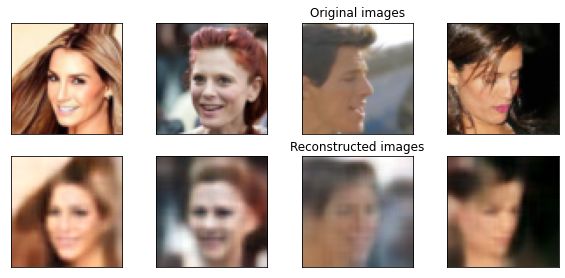

	 partial train loss (single batch): 5789.709961
	 partial train loss (single batch): 5786.592285
	 partial train loss (single batch): 6391.512207
	 partial train loss (single batch): 6046.607422
	 partial train loss (single batch): 6090.651855
	 partial train loss (single batch): 6123.969727
	 partial train loss (single batch): 5569.533203
	 partial train loss (single batch): 6300.728027
	 partial train loss (single batch): 6419.738281
	 partial train loss (single batch): 6241.136230
	 partial train loss (single batch): 5928.972656
	 partial train loss (single batch): 5954.100586
	 partial train loss (single batch): 5685.857422
	 partial train loss (single batch): 5678.502930
	 partial train loss (single batch): 5763.562500
	 partial train loss (single batch): 6698.214355
	 partial train loss (single batch): 6166.106934
	 partial train loss (single batch): 7277.729980
	 partial train loss (single batch): 6260.344238
	 partial train loss (single batch): 6078.406738
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 4/5 	 train loss 92.698 	 validation loss 86.550


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


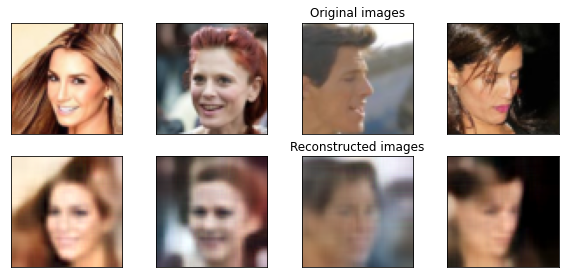

	 partial train loss (single batch): 5368.888672
	 partial train loss (single batch): 5209.536621
	 partial train loss (single batch): 5205.988770
	 partial train loss (single batch): 5755.315918
	 partial train loss (single batch): 4908.937988
	 partial train loss (single batch): 5556.658691
	 partial train loss (single batch): 5606.870117
	 partial train loss (single batch): 5671.923340
	 partial train loss (single batch): 5538.085449
	 partial train loss (single batch): 4931.761230
	 partial train loss (single batch): 5943.588867
	 partial train loss (single batch): 5423.254883
	 partial train loss (single batch): 6055.080566
	 partial train loss (single batch): 5559.551270
	 partial train loss (single batch): 5634.876465
	 partial train loss (single batch): 4951.798828
	 partial train loss (single batch): 5692.044922
	 partial train loss (single batch): 5710.699707
	 partial train loss (single batch): 5300.012207
	 partial train loss (single batch): 5717.236816
	 partial train loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 5/5 	 train loss 86.890 	 validation loss 77.233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


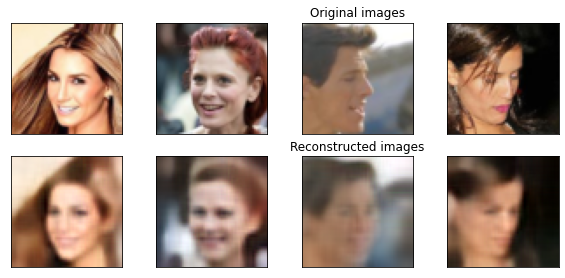

In [30]:
#model = vae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=500, device=device)
model = vae_hyp_celeba.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=100, device=device)
model.to(device)
print(model)
epochs = 5
lr = 5e-4
#lr = 0.01

optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
t_loss = []
v_loss = []
epoch_values =[]
#Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model, trainloader, optimizer)
   val_loss = test_epoch(model, valloader)
   t_loss.append(train_loss)
   v_loss.append(val_loss)
   epoch_values.append(epoch)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t validation loss {:.3f}'.format(epoch + 1, epochs, train_loss, val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)


# save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/resnet_model.pth')

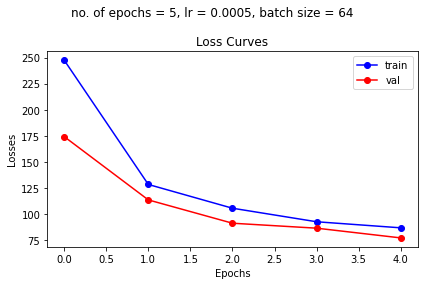

In [31]:
from matplotlib.ticker import FormatStrFormatter

fig , (ax0) = plt.subplots(1, 1)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')


#start, end = ax1.get_ylim()
# ax1.yaxis.set_ticks(np.arange(0.7, 1.0, 0.02))
# ax1.set_ylim(0.7, 1.0)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax0.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64'.format(epochs, lr))
fig.tight_layout()

#Resuming Model Training

In [32]:
# # load the trained model
# model_resume = model.to(device) # initilize the model
# # initialize optimizer  before loading optimizer state_dict
# epochs_new = 5
# learning_rate_new = 5e-4
# optimizer_new = optim.Adam(model_resume.parameters(), lr=learning_rate_new)


# checkpoint = torch.load('outputs/model.pth')

# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')

# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')

# epochs = checkpoint['epoch']
# # load the criterion
# loss_function = checkpoint['loss']
# print('Trained model loss function loaded...')
# print(f"Previously trained for {epochs} number of epochs...")

# # train for more epochs
# epochs = epochs_new
# print(f"Train for {epochs} more epochs...")


# #New Training loop
# for epoch in range(epochs):
#    train_loss = train_epoch(model_resume, trainloader, optimizer_new)
#    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
#    plot_ae_outputs(model.encoder, model.decoder,n=4)

# # save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/model.pth')

#5,3,3,3,5

In [33]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [34]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()